# The Human Movement Recognition Project 

#### A Machine Learning Approach

In [30]:
#All necessary imports to anazlyse, visualise data, train and test models.
import numpy as np 
import pandas as pd 
from scipy import signal
import matplotlib.pyplot as plt 
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [41]:
#Reading the data files essentially making them into ONE 
df1 = pd.read_csv('daliac/dataset_1.txt', sep=',', header=None)
df2 = pd.read_csv('daliac/dataset_2.txt', sep=',', header=None)  
df3 = pd.read_csv('daliac/dataset_3.txt', sep=',', header=None)  
df4 = pd.read_csv('daliac/dataset_4.txt', sep=',', header=None)  
df5 = pd.read_csv('daliac/dataset_5.txt', sep=',', header=None)  
df6 = pd.read_csv('daliac/dataset_6.txt', sep=',', header=None)  
df7 = pd.read_csv('daliac/dataset_7.txt', sep=',', header=None)  
df8 = pd.read_csv('daliac/dataset_8.txt', sep=',', header=None)  
df9 = pd.read_csv('daliac/dataset_9.txt', sep=',', header=None)  
df10 = pd.read_csv('daliac/dataset_10.txt', sep=',', header=None)  
df11 = pd.read_csv('daliac/dataset_11.txt', sep=',', header=None)  
df12 = pd.read_csv('daliac/dataset_12.txt', sep=',', header=None)  
df13 = pd.read_csv('daliac/dataset_13.txt', sep=',', header=None)  
df14 = pd.read_csv('daliac/dataset_14.txt', sep=',', header=None)  
df15 = pd.read_csv('daliac/dataset_15.txt', sep=',', header=None)  
df16 = pd.read_csv('daliac/dataset_16.txt', sep=',', header=None)  
df17 = pd.read_csv('daliac/dataset_17.txt', sep=',', header=None)  
df18 = pd.read_csv('daliac/dataset_18.txt', sep=',', header=None)  
df19 = pd.read_csv('daliac/dataset_19.txt', sep=',', header=None)  

dataset = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19])

In [42]:
print('The dataset contains %d rows.' % len(dataset)) 
dataset.tail()

The dataset contains 4686842 rows.


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
230623,-0.32562,0.79331,-1.1819,-252.10,256.62,280.42,-0.232640,0.078695,0.186110,269.36,...,31.840,-50.976,93.139,-0.050303,0.92783,-0.22923,21.38500,-28.3580,207.88,13
230624,-0.44285,0.70113,-1.2105,-282.86,263.57,286.27,-0.240490,0.220050,0.109720,270.09,...,26.713,-59.398,94.604,-0.022290,0.95868,-0.33081,8.20300,-13.7110,219.59,13
230625,-0.52491,0.64902,-1.2268,-298.60,268.70,295.43,-0.205150,0.381600,0.045393,253.25,...,23.052,-62.693,93.871,0.217820,0.79675,-0.11202,-0.58494,-4.9231,222.52,13
230626,-0.61478,0.60894,-1.1942,-299.70,272.73,307.15,-0.059862,0.490640,-0.022957,215.53,...,20.855,-59.764,91.308,0.137790,0.60398,-0.10420,-6.44360,6.7942,216.66,13
230627,-0.66558,0.58088,-1.1615,-287.25,276.76,319.60,0.069721,0.611800,-0.107390,154.38,...,17.925,-53.905,86.548,-1.146800,6.80350,0.40762,34.56700,14.1180,212.27,13


### Visualising the data recorded from different Chest Sensors 

In [80]:
def data_visulization():
    #lying valaue in dataset: 
    #Chest Accelermeter Sensors: 6,7,8 
    #Chest Gyroscope sensors: 9,10,11
    
    dataset_lying = dataset[dataset[24] == 2].values
    #Data (column 6 to 8) is used for the chest accelerometers
    plt.plot(dataset_lying[:, 6:9])
    plt.show()
    
    #Data (column 9 to 11) is used for the chest gyroscope
    plt.plot(dataset_lying[:, 9:12])
    plt.show()

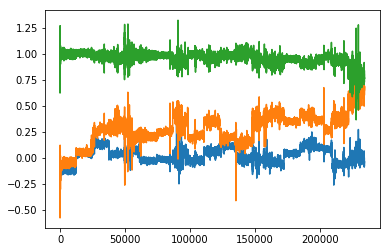

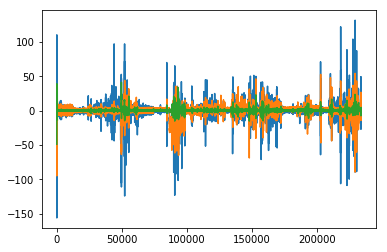

In [81]:
data_visulization()

### Cleaning the selected data and treating it with Noise Reduction

In [82]:
def noise_removing():
    # Butterworth low-pass filter
    b, a = signal.butter(4, 0.04, 'low', analog=False)
    dataset_lying = dataset[dataset[24] == 2].values
    for i in range(6,9):
        dataset_lying[:,i] = signal.lfilter(b, a, dataset_lying[:, i])
    plt.plot(dataset_lying[15000:20000, :3])
    plt.show()
    
    for i in range(9,12):
        dataset_lying[:,i] = signal.lfilter(b, a, dataset_lying[:, i])
    plt.plot(dataset_lying[15000:20000, 4:6])
    plt.show()

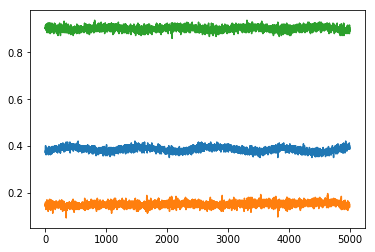

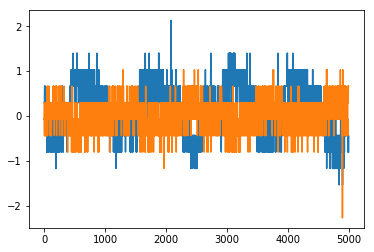

In [83]:
noise_removing()

In [90]:
def feature_engineering():
    training = np.empty(shape=(0, 10))
    testing = np.empty(shape=(0, 10))
    
    # deal with each dataset file
    for i in range(19):
        df = pd.read_csv('daliac/dataset_' + str(i + 1) + '.txt', sep=',', header=None)
        print('Processing dataset: ' + str(i + 1))
        for c in range(1, 14):
            activity_data = df[df[24] == c].values
            b, a = signal.butter(4, 0.04, 'low', analog=False)
            for j in range(24):
                activity_data[:, j] = signal.lfilter(b, a, activity_data[:, j])
            
            data_len = len(activity_data)
            training_len = math.floor(data_len * 0.8)
            training_data = activity_data[:training_len, :]
            testing_data = activity_data[training_len:, :]

            # data segementation: for time series data, 
            #we need to segment the whole time series, and then extract features from each period of time
            # to represent the raw data. In this code, we define each period of time contains 1000 data points. Each period of time contains 
            # different data points. 
            
            training_sample_number = training_len // 1000 + 1
            testing_sample_number = (data_len - training_len) // 1000 + 1

            for s in range(training_sample_number):
                if s < training_sample_number - 1:
                    sample_data = training_data[1000*s:1000*(s + 1), :]
                else:
                    sample_data = training_data[1000*s:, :]
                # in this example code, only three accelerometer data in wrist sensor is used to extract three simple features: min, max, and mean value in
                # a period of time. Finally we get 9 features and 1 label to construct feature dataset. You may consider all sensors' data and extract more

                feature_sample = []
                for i in range(6,9):
                    feature_sample.append(np.min(sample_data[:, i]))
                    feature_sample.append(np.max(sample_data[:, i]))
                    feature_sample.append(np.mean(sample_data[:, i]))
                feature_sample.append(sample_data[0, -1])
                feature_sample = np.array([feature_sample])
                training = np.concatenate((training, feature_sample), axis=0)
            
            for s in range(testing_sample_number):
                if s < training_sample_number - 1:
                    sample_data = testing_data[1000*s:1000*(s + 1), :]
                else:
                    sample_data = testing_data[1000*s:, :]

                feature_sample = []
                for i in range(9,12):
                    feature_sample.append(np.min(sample_data[:, i]))
                    feature_sample.append(np.max(sample_data[:, i]))
                    feature_sample.append(np.mean(sample_data[:, i]))
                feature_sample.append(sample_data[0, -1])
                feature_sample = np.array([feature_sample])
                testing = np.concatenate((testing, feature_sample), axis=0)

    df_training = pd.DataFrame(training)
    df_testing = pd.DataFrame(testing)
    df_training.to_csv('training_data.csv', index=None, header=None)
    df_testing.to_csv('testing_data.csv', index=None, header=None)

In [91]:
feature_engineering()

Processing dataset: 1


KeyboardInterrupt: 

### KNN

In [92]:
def model_training_and_evaluation_KNN():
    df_training = pd.read_csv('training_data.csv', header=None)
    df_testing = pd.read_csv('testing_data.csv', header=None)

    y_train = df_training[9].values
    # Labels should start from 0 in sklearn
    y_train = y_train - 1
    df_training = df_training.drop([9], axis=1)
    X_train = df_training.values

    y_test = df_testing[9].values
    y_test = y_test - 1
    df_testing = df_testing.drop([9], axis=1)
    X_test = df_testing.values
    
    # Feature normalization for improving the performance of machine learning models. In this example code, 
    # RobustScaler#### is used to scale original feature to be centered around zero. You could try other normalization methods.
    scaler = preprocessing.RobustScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Build KNN classifier, in this example code
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)

    # Evaluation. when we train a machine learning model on training set, we should evaluate its performance on testing set.
    # We could evaluate the model by different metrics. Firstly, we could calculate the classification accuracy. In this example
    # code, when n_neighbors is set to 4, the accuracy achieves 0.757.
    y_pred = knn.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    # We could use confusion matrix to view the classification for each activity.
    print(confusion_matrix(y_test, y_pred))
    


In [93]:
model_training_and_evaluation_KNN()

Accuracy:  0.06333973128598848
[[  0  20   0   0   2  13   0   3   0  18   0   0   1]
 [  0  20   0   0   1  17   0   3   0  15   0   0   1]
 [  0  14   0   0   0  10   0   1   0  26   0   0   6]
 [  0   3   0   0   0   3   0   0   0  58   0   0  35]
 [  0  10   0   0   0   1   0   0   0  21   0   0  25]
 [  0   4   0   0   0   3   0   1   0  66   0   0  11]
 [  0   5   0   0   0   4   0   1   0 159   0   0  50]
 [  0   0   0   0   0   1   0   0   0  10   0   0  28]
 [  0  27   0   0   0   1   0   0   0   8   0   0   2]
 [  0   1   0   0   0   0   0   0   0  43   0   0  52]
 [  0   0   0   0   0   2   0   1   0  67   0   0  30]
 [  0   0   0   0   0   1   0   0   0  69   0   0  30]
 [  0   0   0   0   0   1   0   0   0  37   0   0   0]]


### SVM

In [108]:
def model_training_and_evaluation_SVM():
    df_training = pd.read_csv('training_data.csv', header=None)
    df_testing = pd.read_csv('testing_data.csv', header=None)

    y_train = df_training[9].values
    # Labels should start from 0 in sklearn
    y_train = y_train - 1
    df_training = df_training.drop([9], axis=1)
    X_train = df_training.values

    y_test = df_testing[9].values
    y_test = y_test - 1
    df_testing = df_testing.drop([9], axis=1)
    X_test = df_testing.values
    
    # Feature normalization for improving the performance of machine learning models. In this code, 
    # StandardScaler is used to scale original feature to be centered around zero. You could try other normalization methods.
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2, 1e-3, 1e-4],
                     'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 100]},
                    {'kernel': ['linear'], 'C': [1e-3, 1e-2, 1e-1, 1, 10, 100]}]
    acc_scorer = make_scorer(accuracy_score)
    grid_obj  = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring=acc_scorer)
    grid_obj  = grid_obj .fit(X_train, y_train)
    clf = grid_obj.best_estimator_
    print('best clf:', clf)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    


In [ ]:
model_training_and_evaluation_SVM()